<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
 The Hanging Chain Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Hanging Chain Problem:* We aim to find the chain (of uniform density) of length `L` suspended between two points `a` and `b` with minimal potential energy.                
The problem is inspired from the following paper: [Benchmarking Optimization Software with COPS 3.0](https://www.mcs.anl.gov/~more/cops/cops3.pdf).                             
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

## 1. Solving with JuMP <a id='jump'></a>

In [1]:
using JuMP , Ipopt
include("../Problems/JuMP/chain_JMP.jl")
ChainJMP = chain_JMP();

set_optimizer(ChainJMP,Ipopt.Optimizer)
set_attribute(ChainJMP, "print_level", 5)
set_optimizer_attribute(ChainJMP,"tol",1e-8)
set_optimizer_attribute(ChainJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(ChainJMP,"max_iter",1000)
set_optimizer_attribute(ChainJMP,"mu_strategy","adaptive")
set_optimizer_attribute(ChainJMP,"linear_solver","mumps")

In [2]:
println("Solving...")
optimize!(ChainJMP)
println()

# Display results
if termination_status(ChainJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(ChainJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(ChainJMP) == MOI.TIME_LIMIT && has_values(ChainJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(ChainJMP))
println()


# Retrieves values of variables
N = 200
L = 4.0
a = 1.0
b = 3.0
tf = 1.0
h = tf / N
x1_ = ChainJMP[:x1];
x2_ = ChainJMP[:x2];
x3_ = ChainJMP[:x3];
u_ = ChainJMP[:u];

con_x1 = ChainJMP[:con_x1];
con_x2 = ChainJMP[:con_x2];
con_x3 = ChainJMP[:con_x3];

Δtt = value.(h)
t = Vector((0:N)*Δtt); 
p = [ [ dual(con_x1[1]), dual(con_x2[1]), dual(con_x3[1]) ] ];
p = - [p; [[ dual(con_x1[i]), dual(con_x2[i]), dual(con_x3[i]) ] for i in 1:N] ];



x1 = Vector(value.(x1_)) ;
x2 = Vector(value.(x2_)) ;
x3 = Vector(value.(x3_));
u = Vector(value.(u_)) ;

x =  [ [ x1[i], x2[i], x3[i] ] for i in 1:N+1 ];


Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2805
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1600

Total number of variables............................:      804
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      605
Total number of i

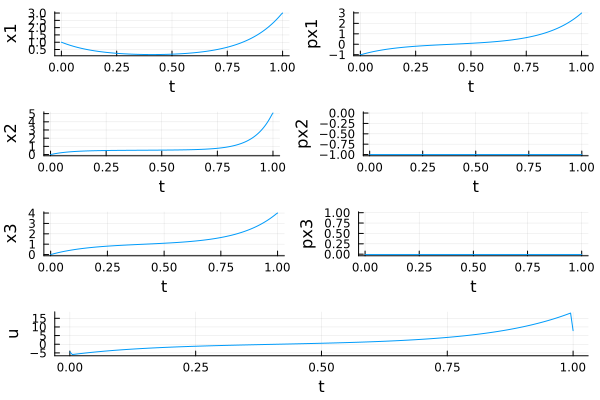

In [9]:
# For plotting results
using Plots

x1_plot = plot(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "x1", legend = false)
x2_plot = plot(t, [ x[i][2] for i in 1:N+1], xlabel = "t", ylabel = "x2", legend = false)
x3_plot = plot(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "x3", legend = false)
px1_plot = plot(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "px1", legend = false)
px2_plot = plot(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "px2", legend = false)
px3_plot = plot(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "px3", legend = false)
u_plot = plot(t, [ u[i] for i in 1:N+1 ], xlabel = "t", ylabel = "u", legend = false)

layout = @layout [a b; c d; e f; g]
x_plot = plot(x1_plot, px1_plot, x2_plot, px2_plot, x3_plot, px3_plot, u_plot, layout = layout)
display(x_plot)

## 2. Solving with OptimalControl <a id='oc'></a>

In [4]:
using OptimalControl
include("../Problems/OptimalControl/chain_OC.jl")
ChainOC = chain_OC()


The (autonomous) optimal control problem is of the form:

    minimize  J(x, u) = g(x(0), x(1.0))

    subject to

        ẋ(t) = f(x(t), u(t)), t in [0, 1.0] a.e.,

        ϕl ≤ ϕ(x(0), x(1.0)) ≤ ϕu, 

    where x(t) ∈ R³ and u(t) ∈ R.

Declarations (* required):



┌────────┬────────┬──────────┬──────────┬───────────┬────────────┬─────────────┐
│ times* │ state* │ control* │ variable │ dynamics* │ objective* │ constraints │
├────────┼────────┼──────────┼──────────┼───────────┼────────────┼─────────────┤
│     ✅ │     ✅ │       ✅ │       ❌ │        ✅ │         ✅ │          ✅ │
└────────┴────────┴──────────┴──────────┴───────────┴────────────┴─────────────┘


In [5]:
# Initial guess
nh = 200
L = 4.0
a = 1.0
b = 3.0
tf = 1.0
h = tf / nh
tmin = b > a ? 1 / 4 : 3 / 4

xinit = [4 * abs(b - a) * (1:nh+1) / nh .* (1 / 2 * (1:nh+1) / nh .- tmin) .+ a,
        (4 * abs(b - a) * (1:nh+1) / nh .* (1 / 2 * (1:nh+1) / nh .- tmin) .+ a) .* (4 * abs(b - a) * ((1:nh+1) / nh .- tmin)),
        4 * abs(b - a) * ((1:nh+1) / nh .- tmin) ]
uinit = 4 * abs(b - a) * ((1:nh+1) / nh .- tmin)
init = (x_init = xinit, u_init = uinit)
# Solve the problem
sol = OptimalControl.solve(ChainOC,init=init)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     1405
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      202

Total number of variables............................:      404
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      305
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 3.90e+00 4.45e-03   0.

CTBase.OptimalControlSolution

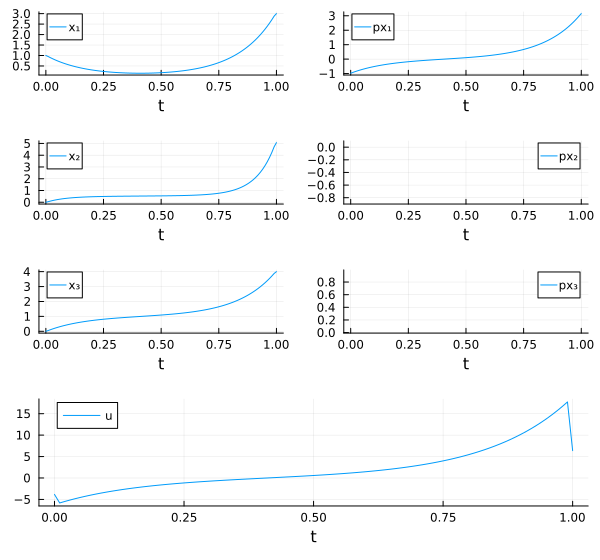

In [6]:
# Plot results
plot(sol)

## 3. Comparison <a id='comp'></a>

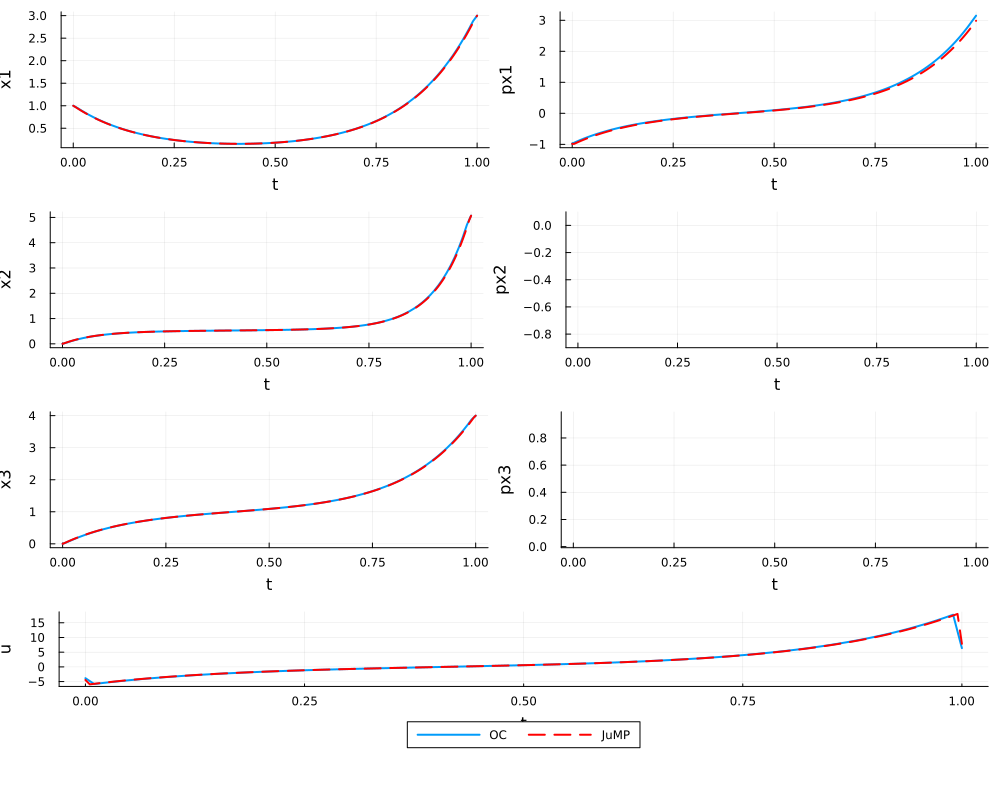

In [8]:
using Plots
p1 = plot(plot(sol)[1],line = 2)
p1 = plot!(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "x1", legend = false,line = 2, color = "red",linestyle=:dash)

p3 = plot(plot(sol)[2],line = 2)
p3 = plot!(t, [ x[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "x2", legend = false,line = 2, color = "red",linestyle=:dash)

p5 = plot(plot(sol)[3],line = 2)
p5 = plot!(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "x3", legend = false,line = 2, color = "red",linestyle=:dash)

p2 = plot(plot(sol)[4],line = 2)
p2 = plot!(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "px1", legend = false,line = 2, color = "red",linestyle=:dash)

p4 = plot(plot(sol)[5],line = 2)
p4 = plot!(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "px2", legend = false,line = 2, color = "red",linestyle=:dash)

p6 = plot(plot(sol)[6],line = 2)
p6 = plot!(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "px3", legend = false,line = 2, color = "red",linestyle=:dash)

p7 = plot(plot(sol)[7] , label ="OC",line = 2)
p7 = plot!(t, [u[i] for i in 1:N+1 ], xlabel = "t", ylabel = "u", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
p7 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g];

x_plot = plot(p1, p2, p3, p4, p5, p6, p7, layout = layout, size = (1000, 800))

display(x_plot)